# NTSB Feature Selection

This notebook examines the rates of missingness for each value in the master NTSB dataset, as well as population for dummy variables, allowing us to pare down features which may not be likely to be useful/predictive.

### Note: 
This notebook employs the **'missingno'** package, which can be installed with a "pip install missingno" command in your Terminal.
***


In [1]:
import pandas as pd
import missingno as mno
import matplotlib.pyplot as plt
import numpy as np

In [18]:
data = pd.read_csv("../data/ntsb/cleaned/master_train.csv")

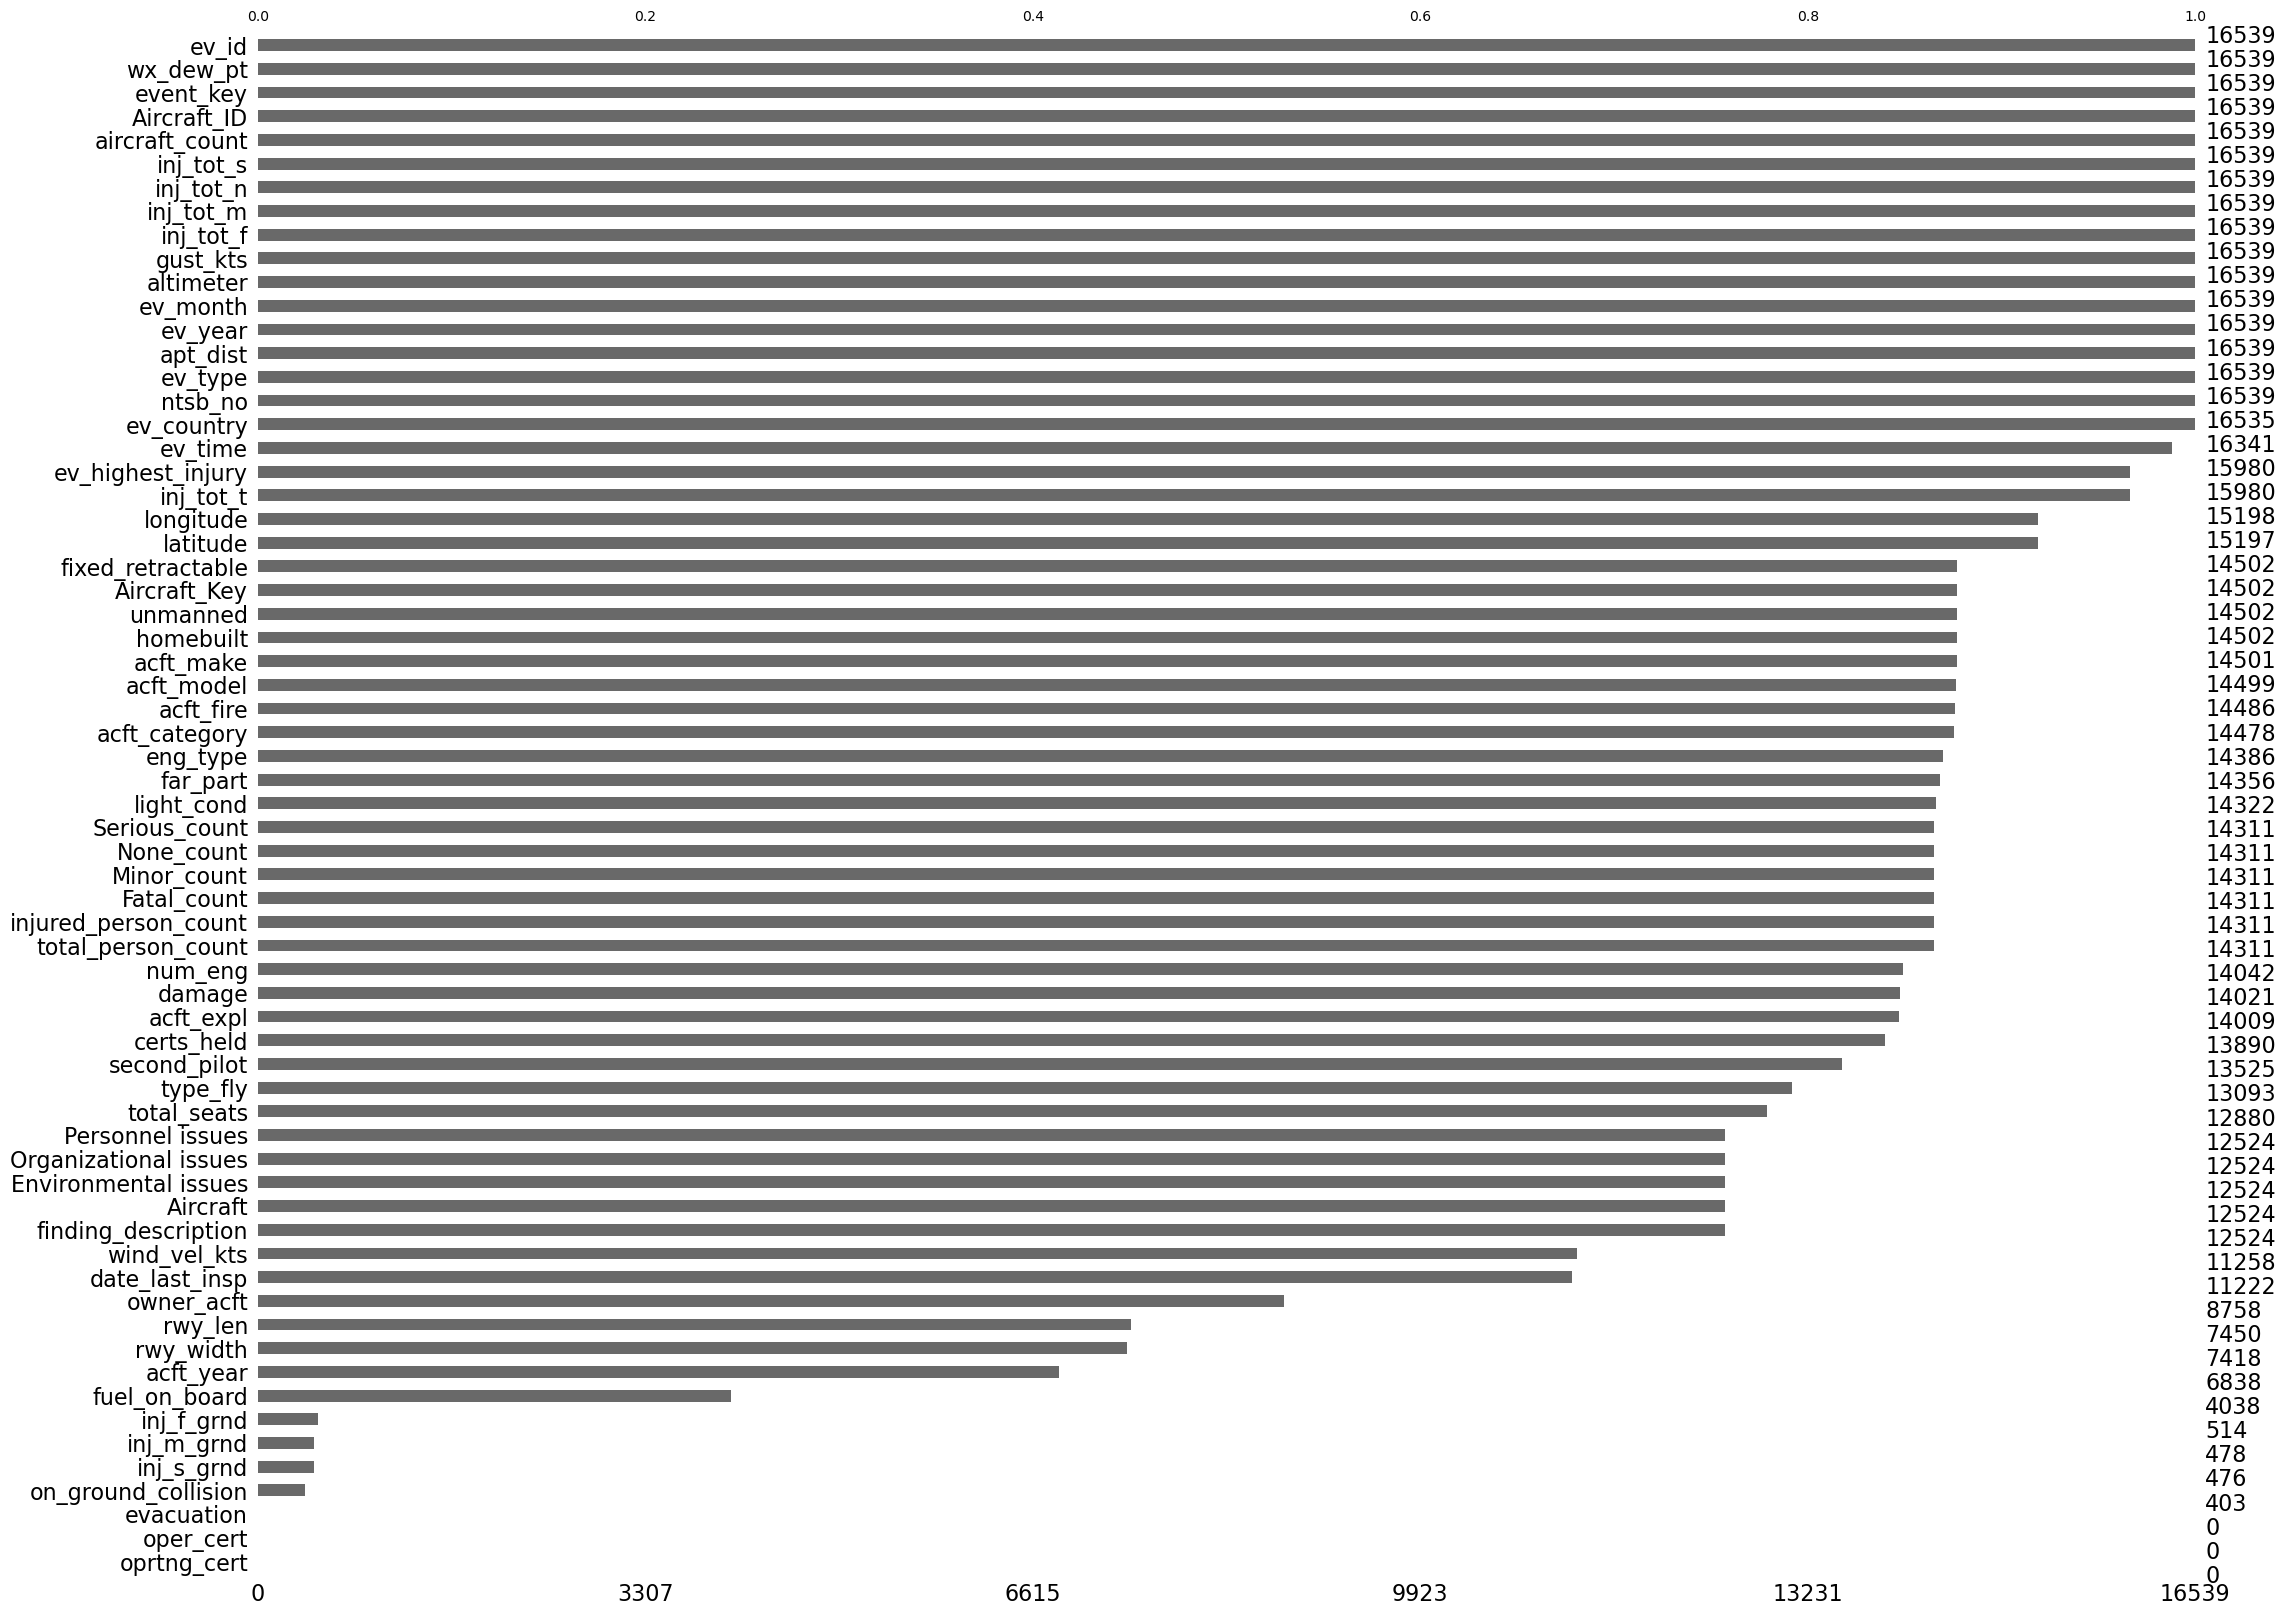

In [30]:
mno.bar(data, sort='ascending')
plt.show()

### Handling missing values

Eventually when we impute values, I think we should do so __before__ dropping any columns / infrequent values of categorical variables because we may use that information in imputation even if we don't use it in modeling. E.g. if we only two occurences of a particular aircraft model, that could still be useful for imputing missing info about the aircraft.

#### `total_person_count`
We have some missing data for `total_person_count`, which can mostly be calculated, but:
1. there are a few (~10) cases where we're missing data for both aircraft in a multi-aircraft event. 
2. if `inj_tot_t` and aircraft-level counts are missing and the other event-level injury counts are 0, this does not necessarily indicate that there were only unmanned aircraft involved. It seems that the other event-level injury counts default to 0 when they are unknown, and only `inj_tot_t` is left blank in the dataset.

I found the following reasons why the injury counts might be unknown:
- Crash occurred outside of the USA --> no NTSB investigation
- Incident and not accident --> superficial investigation
- Aircraft damage was discovered in an inspection --> investigation could not determine whether injuries occurred

#### Filtering data
- I think we should filter out (a) events outside the USA and (b) non-accidents because of a high likelihood of sparse data. This leaves us with ~83% of the data. 
- If we do this, most of the variables now have well over 80% of the values present
- My gut is to filter before the train-test split, but I'm not certain that's right (or that it matters)

#### Other notes
- I find it suspicious that `gust_kts` is 100% present but `wind_vel_kts` is ~20% missing. My guess is that the system defaults to put 0 when `gust_kts` is unknown

In [25]:
data_acc_usa = data.loc[(data['ev_country']=='USA') & (data['ev_type']=='ACC')]

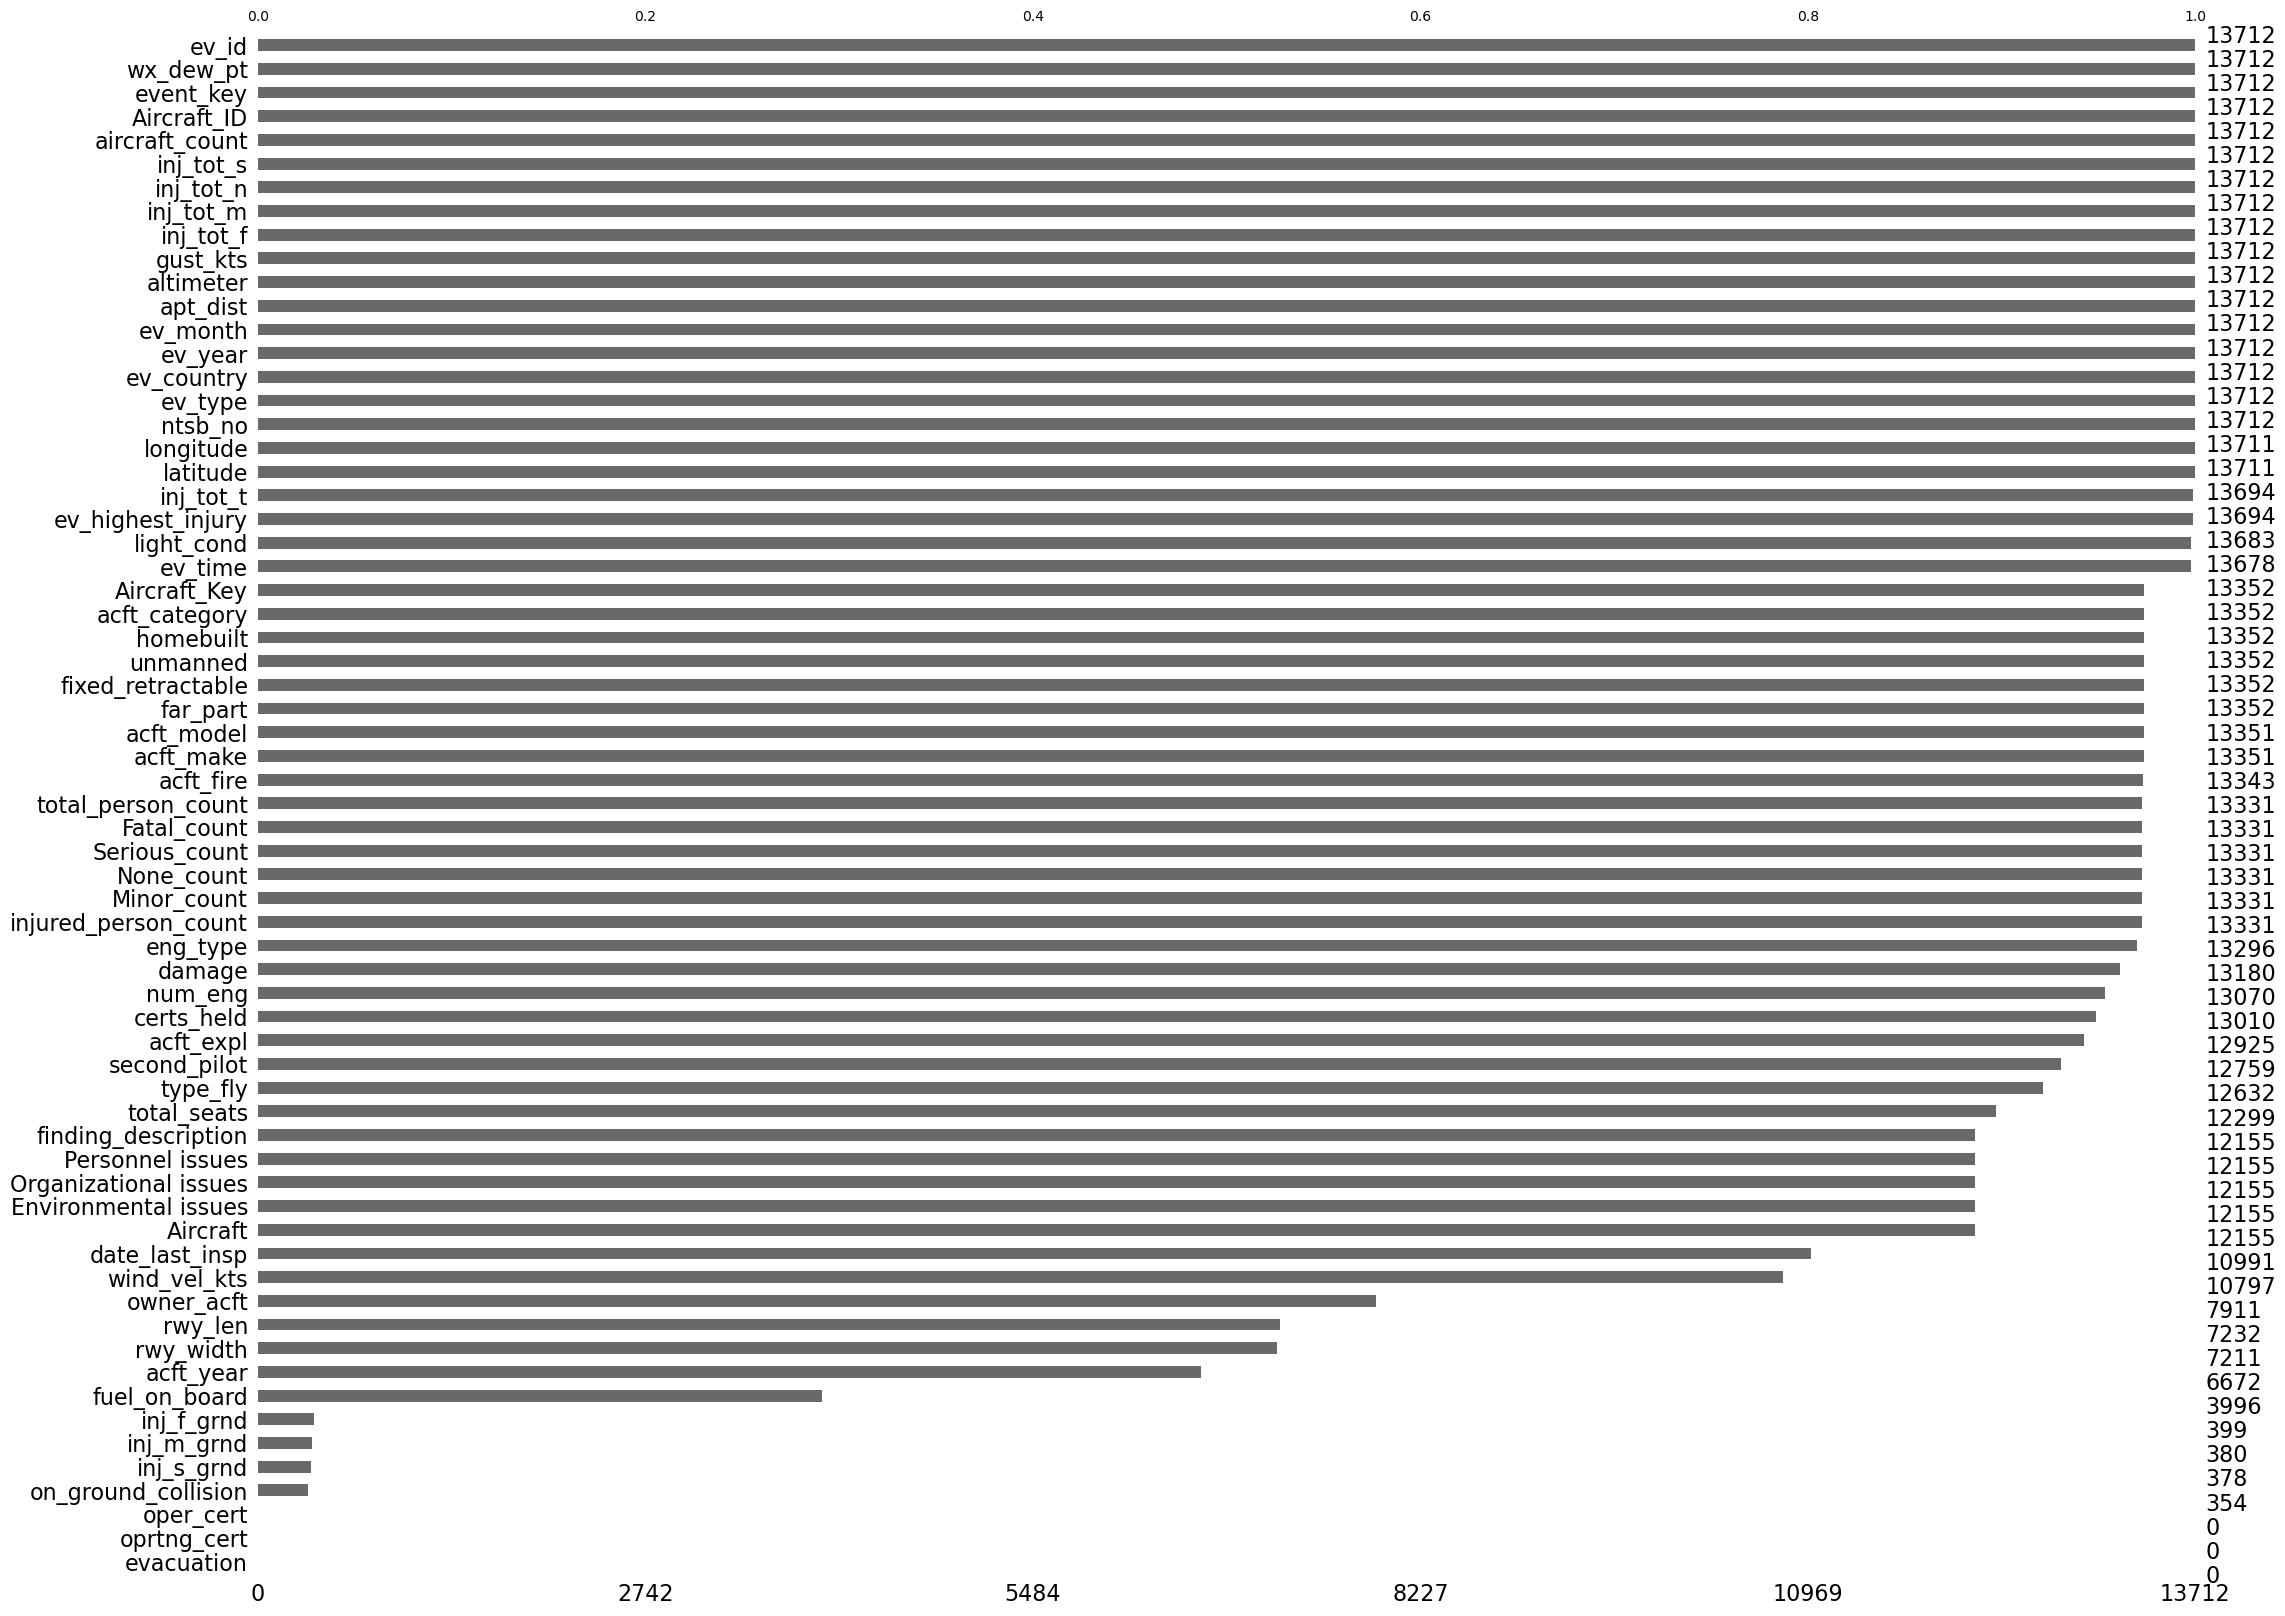

In [26]:
mno.bar(data_acc_usa, sort='ascending')
plt.show()

### Drop columns we don't need

In [ ]:
# Already processed
data.drop(columns=['Aircraft_ID', 'ev_id', 'finding_description'], inplace=True)

In [ ]:
# Possible data leakages
data.drop['acft_fire', 'acft_explode']

#### Notes 
- Since we don't want to drop columns based on their frequency in the test set, this is probably a temporary measure to simplify our exploration, but we can take it out once we have a model
- The following should be run __before__ drop infrequent values, which fills in missing entries

In [187]:
def drop_sparse_columns(data, threshold, safe_cols=None):
    '''
    Drops columns from data that do not contain at least a given proportion of non-empty entries
    
    Inputs
        data: pandas DataFrame
        threshold: float in [0,1], all columns with less than this proportion of non-empty entries are dropped
        safe_cols: list of names of columns that should not be dropped even if they are below the sparsity threshold
    Outputs
        data: same DataFrame with appropriate columns dropped
    '''
    # list of columns to drop if they are too sparse
    unsafe_cols = [col for col in data.columns if col not in safe_cols]

    for col in unsafe_cols:
        # calculate proportion of na entries in col
        prop_na = data[col].isna().sum() / len(data)
        
        # drop col if the column is too sparse
        if prop_na > 1 - threshold:
            data.drop(columns=col, inplace=True)
    
    return data

In [188]:
data = drop_sparse_columns(data, 0.8, safe_cols=['damage', 'acft_category', 'acft_make', 'acft_model'])

### Drop infrequent values of categorical variables

Note: when we go to build the model, we'll have to make sure we're dropping values based on their frequency in the training set and NOT based on their frequency in the test set

In [189]:
def drop_infrequent_values(data, columns, threshold):
    '''
    For each of the specified columns, find the values that occur with frequency lower than the threshold,
    and replace these values and missing values by 'other/unknown'.
    This is only intended for categorical variables
    
    Inputs
        data: pandas DataFrame
        columns: list of column names to simplify
        threshold: float in [0,1], frequency threshold for removing 
    Outputs
        data: pandas DataFrame
    '''

    freq_thresh = threshold * len(data)

    for col in columns:
        counts = data[col].value_counts()
        
        for i in counts.index:
            if counts[i] < freq_thresh:
                data.loc[data[col]==i, col] = 'other/unknown'
        
        data.loc[data[col].isna(), col] = 'other/unknown'

    return data

In [190]:
categorical_vars = ['ev_type', 'light_cond', 'eng_type', 'certs_held', 'fixed_retractable', 
                    'second_pilot']

new_data = drop_infrequent_values(data, categorical_vars, 0.03)

In [192]:
new_data.columns

Index(['ntsb_no', 'ev_type', 'ev_time', 'ev_country', 'ev_year', 'ev_month',
       'latitude', 'longitude', 'apt_dist', 'light_cond', 'wx_dew_pt',
       'gust_kts', 'altimeter', 'ev_highest_injury', 'inj_tot_f', 'inj_tot_m',
       'inj_tot_n', 'inj_tot_s', 'inj_tot_t', 'aircraft_count', 'event_key',
       'Aircraft_Key', 'eng_type', 'far_part', 'damage', 'acft_fire',
       'acft_expl', 'acft_make', 'acft_model', 'acft_category', 'homebuilt',
       'num_eng', 'fixed_retractable', 'certs_held', 'second_pilot',
       'unmanned', 'Fatal_count', 'Minor_count', 'None_count', 'Serious_count',
       'total_person_count', 'injured_person_count'],
      dtype='object')

### Feature engineering

In [193]:
# Calculate number of people onboard and the proportion in each injury level

data['num_people_onboard'] = data['inj_tot_f'] + data['inj_tot_m'] + data['inj_tot_n'] + data['inj_tot_s']
data['prop_onboard_inj'] =  (data['num_people_onboard'] - data['inj_tot_n'])/ data['num_people_onboard']
data['prop_onboard_inj_m'] =  data['inj_tot_m'] / data['num_people_onboard']
data['prop_onboard_inj_s'] =  data['inj_tot_s'] / data['num_people_onboard']
data['prop_onboard_inj_f'] =  data['inj_tot_f'] / data['num_people_onboard']